# Machine Learning And DM Project 3

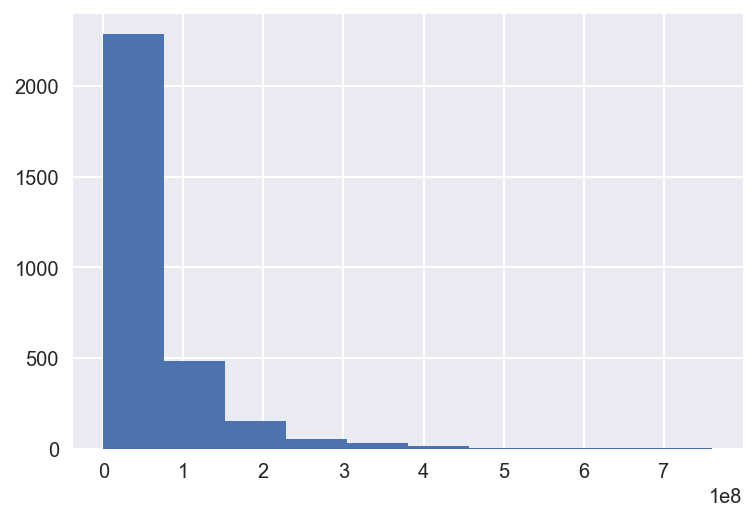

In [65]:
%matplotlib inline 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

data = pd.Series({})
data['raw'] = pd.read_csv("movie_metadata.csv")
data['reduced'] = data['raw'][data['raw']['country'] == 'USA']
data['reduced'] = data['reduced'].drop(['actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes', 
                                        'cast_total_facebook_likes', 'director_facebook_likes', 'movie_facebook_likes',
                                        'aspect_ratio', 'facenumber_in_poster'], axis=1)
data['reduced'] = data['reduced'].dropna()
data['numerical'] = data['reduced'].select_dtypes(exclude=['object'])
data['standardized'] = StandardScaler().fit_transform(data['numerical'].values)
data['standardized'] = pd.DataFrame(data['standardized'], columns=data['numerical'].columns.values)
data['numerical']['gross'].hist();

1    1593
0     888
2     551
Name: gross_class, dtype: int64

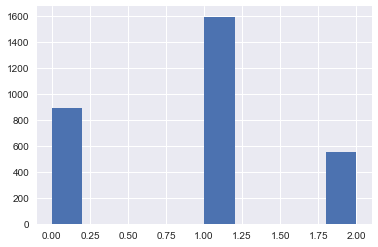

In [2]:
def clf(value):
    limits = [0.15e8, 1.0e8]
    if value < limits[0]:
        return 0 # Low gross movies
    elif (value >= limits[0]) & (value <= limits[1]):
        return 1 # Medium gross movies
    else:
        return 2 # Higher income movies
    
data['numerical']['gross_class'] = data['numerical']['gross'].apply(clf);
data['numerical']['gross_class'].hist();
data['numerical']['gross_class'].value_counts()

Clustering:
     1. Cluster your data by the Gaussian Mixture Model (GMM) and use crossvalidation to estimate the number of components in the GMM. Try to interpret the extracted cluster centers.

In [3]:
from matplotlib.pyplot import figure, plot, legend, xlabel, show
import numpy as np
from scipy.io import loadmat
from sklearn.mixture import GaussianMixture
from sklearn import cross_validation

X = data['numerical'].drop(['gross', 'gross_class'], axis=1).values
#y = data['numerical'][['gross_class']].values
N, M = X.shape

We use 

1...2...3...4...5...6...7...8...9...10...

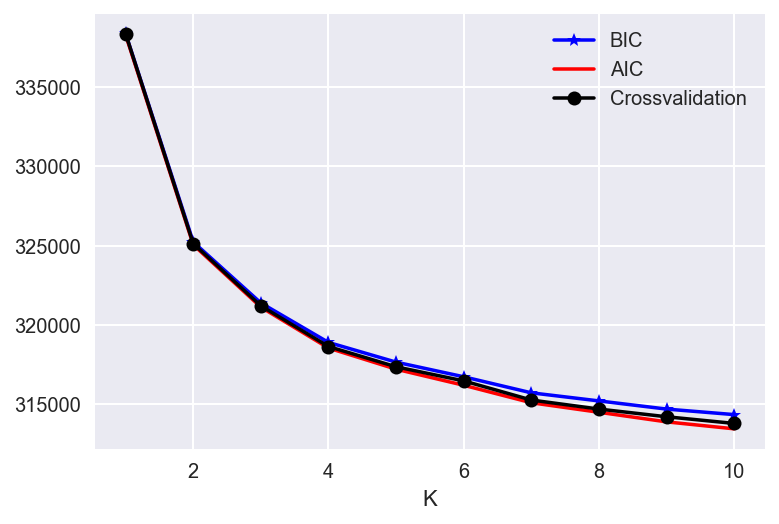

In [30]:
# Range of K's to try
KRange = range(1,11)
T = len(KRange)

covar_type = 'diag'     # you can try out 'diag' as well
reps = 3                # number of fits with different initalizations, best result will be kept

# Allocate variables
BIC = np.zeros((T,))
AIC = np.zeros((T,))
CVE = np.zeros((T,))

# K-fold crossvalidation
CV = cross_validation.KFold(N,10,shuffle=True)

for t,K in enumerate(KRange):
        print('{0}...'.format(K), sep=' ', end='', flush=True)
        #print('Fitting model for K={0}\n'.format(K))

        # Fit Gaussian mixture model
        gmm = GaussianMixture(n_components=K, covariance_type=covar_type, n_init=reps).fit(X)

        # Get BIC and AIC
        BIC[t,] = gmm.bic(X)
        AIC[t,] = gmm.aic(X)

        # For each crossvalidation fold
        for train_index, test_index in CV:
            #print(train_index)
            # extract training and test set for current CV fold
            X_train = X[train_index]
            X_test = X[test_index]

            # Fit Gaussian mixture model to X_train
            gmm = GaussianMixture(n_components=K, covariance_type=covar_type, n_init=reps).fit(X_train)

            # compute negative log likelihood of X_test
            CVE[t] += -gmm.score_samples(X_test).sum()
            

# Plot results

figure(1); 
plot(KRange, BIC,'-*b')
plot(KRange, AIC,'-xr')
plot(KRange, 2*CVE,'-ok')
legend(['BIC', 'AIC', 'Crossvalidation'])
xlabel('K')
show()

On the above figure we can see that 10 components might be suitable.

In [36]:
from sklearn.mixture import GaussianMixture

In [41]:
from matplotlib.pyplot import figure, show
import numpy as np
from scipy.io import loadmat
from toolbox_02450 import clusterplot
#from sklearn.mixture import GaussianMixtureClustering

ValueError: shapes (7,7) and (2,100) not aligned: 7 (dim 1) != 2 (dim 0)

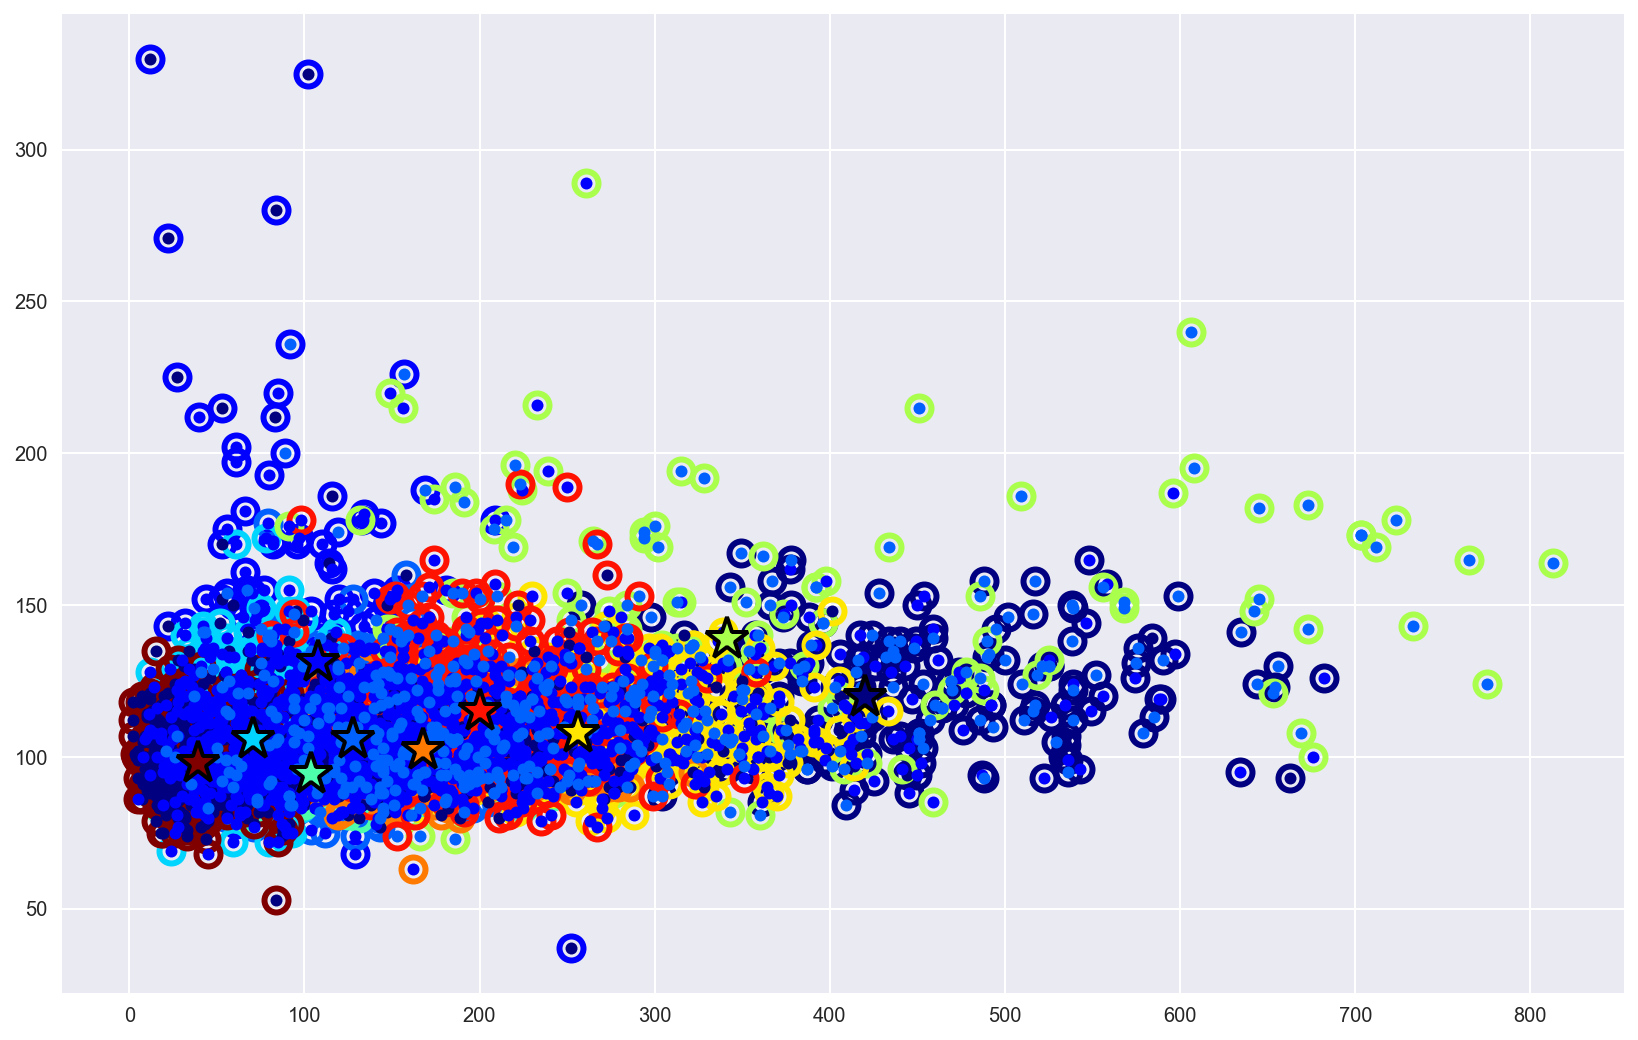

In [43]:
K = 10                      # Number of clusters
cov_type = 'diag'           # type of covariance, you can try out 'diag' as well
reps = 3                    # number of fits with different initalizations, best result will be kept
gmm = GaussianMixture(n_components=K, covariance_type=cov_type, n_init=reps).fit(X)# Fit Gaussian mixture model
cls = gmm.predict(X)        # extract cluster labels
cds = gmm.means_            # extract cluster centroids (means of gaussians)
covs = gmm.covariances_     # extract cluster shapes (covariances of gaussians)

if cov_type == 'diag':    
    new_covs = np.zeros([K,M,M])    

count = 0    
for elem in covs:        
    temp_m = np.zeros([M,M])        
    for i in range(len(elem)):            
        temp_m[i][i] = elem[i]        
    
    new_covs[count] = temp_m        
    count += 1
        
covs = new_covs
y = data['numerical'][['gross_class']].values


# Plot results:
figure(figsize=(14,9))
clusterplot(X, clusterid=cls, centroids=cds, y=y, covars=covs)
show()

In [47]:
cls

array([0, 0, 0, ..., 0, 0, 0])

It is not possible to directly interpret the clusters.

     2. Perform a hierarchical clustering of your data using a suitable dissimilarity measure and linkage function. Try to interpret the results of the hierarchical clustering.

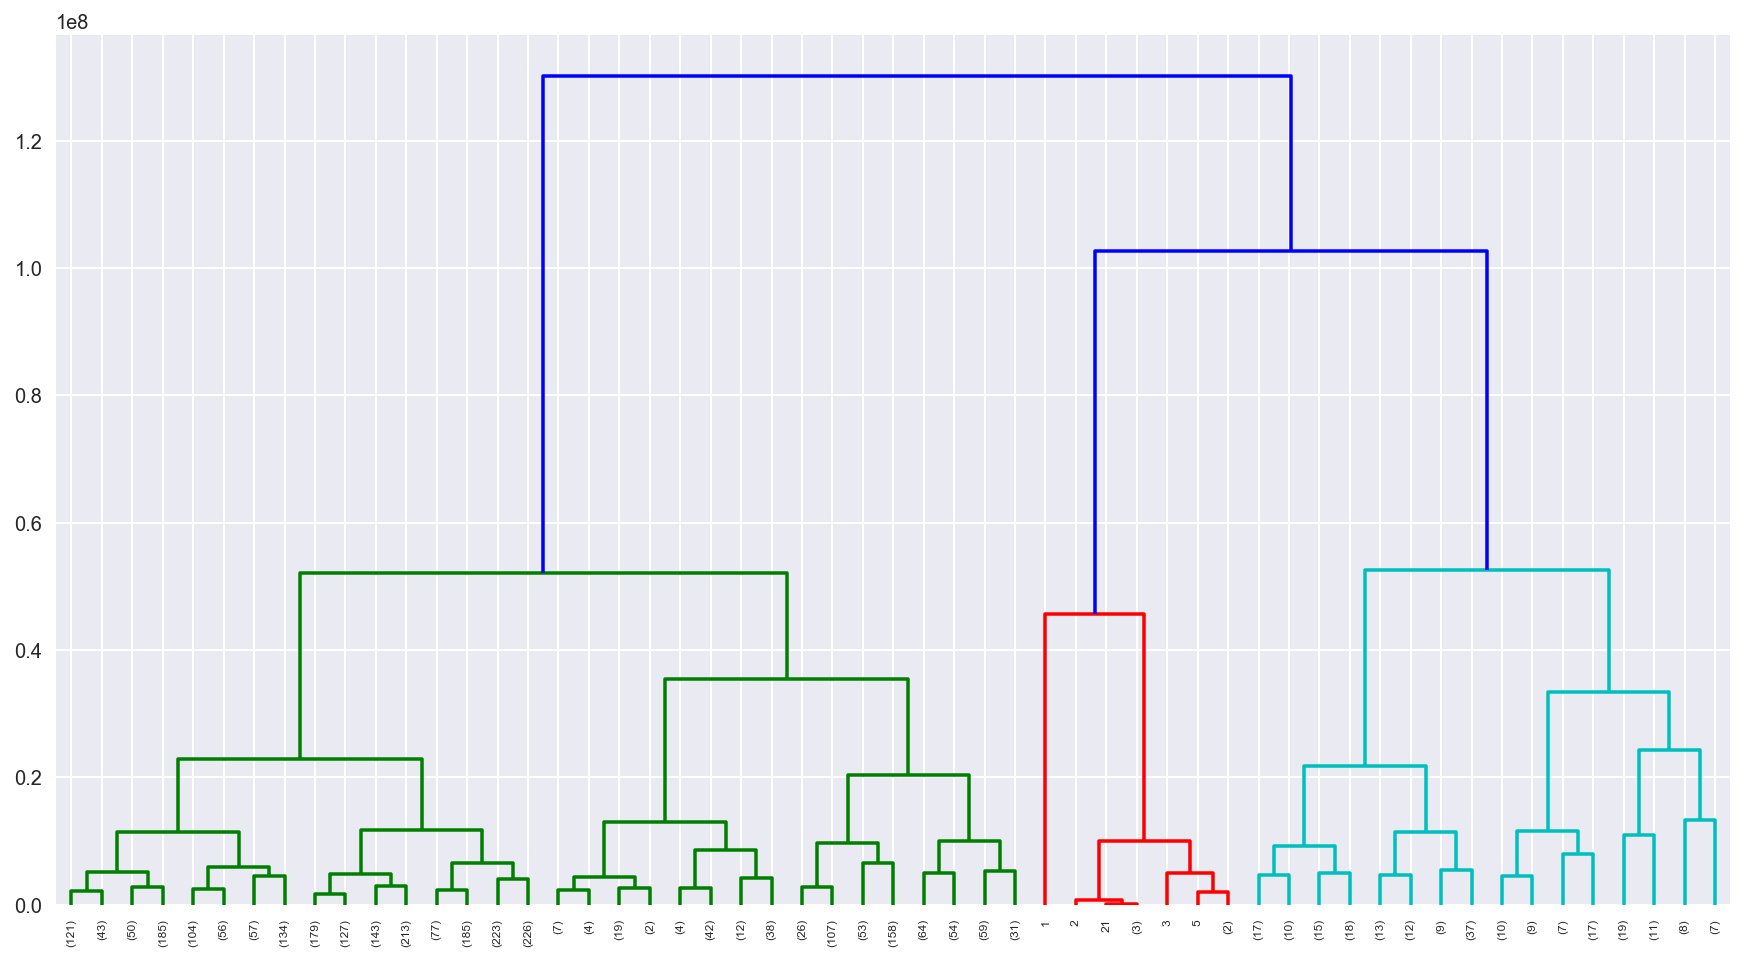

In [33]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
%config InlineBackend.figure_format = 'retina'

# Perform hierarchical/agglomerative clustering on data matrix
Method = 'average'
Metric = 'euclidean'

Z = linkage(X, method=Method, metric=Metric)

# Compute and display clusters by thresholding the dendrogram
#Maxclust = 8
#cls = fcluster(Z, criterion='maxclust', t=Maxclust)
#figure(1)
#clusterplot(X, cls.reshape(cls.shape[0],1), y=y)

# Display dendrogram
max_display_levels=5
figure(2,figsize=(15,8))
dendrogram(Z, truncate_mode='level', p=max_display_levels)
show()

From the above graph we can see that only one movie is given the "blue class".
Dengrogram height indicates dissimilarity, higher is less similar. We can check if the clustering is a good indicator for the classes we would like to predict.

In the ideal situation we would see movie number 41 and 44 (clustered to be similar) have the same gross class.

In [39]:
c1 = 121
c2 = 43
print(data['numerical'].iloc[c1]['gross_class'])
print(data['numerical'].iloc[c2]['gross_class'])

2.0
2.0


We can see that the movies with index 41 and 44 are NOT the same gross_class. From this we can infer that gross_class might not be a good way to differentiate movies, which does not add support for our hyphothesis.

     3. Evaluate the quality of the clustering in terms of your label information for the GMM as well as for the hierarchical clustering where the cut-off is set at the same number of clusters as estimated by the GMM.

In [48]:
# exercise 10.1.3
from matplotlib.pyplot import figure, title, plot, ylim, legend, show
import numpy as np
from scipy.io import loadmat
from toolbox_02450 import clusterval
from sklearn.cluster import k_means

X = data['numerical'].drop(['gross', 'gross_class'], axis=1).values
y = data['numerical'][['gross_class']].values
N, M = X.shape

# Maximum number of clusters:
K = 10

# Allocate variables:
Rand = np.zeros((K,))
Jaccard = np.zeros((K,))
NMI = np.zeros((K,))

for k in range(K):
    # run K-means clustering:
    #cls = Pycluster.kcluster(X,k+1)[0]
    centroids, cls, inertia = k_means(X,k+1)
    # compute cluster validities:
    Rand[k], Jaccard[k], NMI[k] = clusterval(y,cls)    
        
# Plot results:
figure(1)
title('Cluster validity')
plot(np.arange(K)+1, Rand)
plot(np.arange(K)+1, Jaccard)
plot(np.arange(K)+1, NMI)
ylim(-2,1.1)
legend(['Rand', 'Jaccard', 'NMI'], loc=4)
show()

ValueError: labels_true must be 1D: shape is (3032, 1)

# Association mining

In this part of the report you are to investigate if there are associations among your attributes based on association mining. In order to do so you will need to make your data binary, see also exercise 11. 
% (For categoric variables you can use the one-out-of-K coding format).
% You will need to save the binarized data into a text file that can be analyzed by the Apriori algorithm.

    1. Run the Apriori algorithm on your data and find frequent itemsets as well as association rules with high confidence.
    2. Try and interpret the association rules generated.

What is the support for a specific genre ie. "Action".
    How many movies have the "Action" genre
What is the confidence for a specific itemset (genre) ie. {Action} -> {Comedy}
    

In [46]:
import pandas as pd
import collections
import numpy as np

data = pd.Series({})
data['raw'] = pd.read_csv("movie_metadata.csv")
data['reduced'] = data['raw'][data['raw']['country'] == 'USA']
data['reduced'] = data['reduced'].drop(['actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes', 
                                        'cast_total_facebook_likes', 'director_facebook_likes', 'movie_facebook_likes',
                                        'aspect_ratio', 'facenumber_in_poster'], axis=1)
data['reduced'] = data['reduced'].dropna()
data['AM'] = data['reduced'].copy()
data['AM']['genres'] = data['AM']['genres'].apply(lambda x: x.split('|'))
data['AM']['genres'].to_csv('mydata.txt')

# Number encoded genre representations
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
fitlist = [value for inner in data['AM']['genres'].tolist() for value in inner]
le.fit(fitlist)
data['AM']['genres_encoded'] = data['AM']['genres'].apply(le.transform)
# data['AM']['genres_encoded'].head()

In [50]:
import os
import re

minSup = 20
minConf = 40
maxRule = 10

# Run external program for Apriori algorithme
os.system('apriori.exe -f"," -s{0} -v"[Sup. %S]" newdata.txt apriori_temp1.txt'.format(minSup))
os.system('apriori.exe -tr -f"," -n{0} -c{1} -s{2} -v"[Conf. %C, Sup. %S]" newdata.txt apriori_temp2.txt'.
          format(maxRule, minConf, minSup))

# Extract Frequent Itemsets
lines = open('apriori_temp1.txt', 'r').readlines()
FrequentItemsets = [''] * len(lines)
sup = np.zeros((len(lines), 1))
for i, line in enumerate(lines):
    FrequentItemsets[i] = line[0:-1]
    sup[i] = re.findall(' [-+]?\d*\.\d+|\d+]', line)[0][1:-1]
os.remove('apriori_temp1.txt')

# Extract Association rules
lines = open('apriori_temp2.txt', 'r').readlines()
AssocRules = [''] * len(lines)
conf = np.zeros((len(lines), 1))
for i, line in enumerate(lines):
    AssocRules[i] = line[0:-1]
    conf[i] = re.findall(' [-+]?\d*\.\d+|\d+,', line)[0][1:-1]
os.remove('apriori_temp2.txt')

# sort (FrequentItemsets by support value, AssocRules by confidence value)
AssocRulesSorted = [AssocRules[item] for item in np.argsort(conf, axis=0).ravel()]
AssocRulesSorted.reverse()
FrequentItemsetsSorted = [FrequentItemsets[item] for item in np.argsort(sup, axis=0).ravel()]
FrequentItemsetsSorted.reverse()

# Print the results
print('Frequent itemsets:')
for i, item in enumerate(FrequentItemsetsSorted):
    print('Item: {0}'.format(item))
print('\nAssociation rules:')
for i, item in enumerate(AssocRulesSorted):
    print('Rule: {0}'.format(item))

Frequent itemsets:
Item: 'Thriller']"[Sup. 28]
Item: "['Action'[Sup. 25]
Item: "['Comedy'[Sup. 24]
Item: 'Drama'[Sup. 23]

Association rules:
Rule: "['Action' <- 'Thriller']"[Conf. 44, Sup. 12]
Rule: 'Romance']" <- "['Comedy'[Conf. 44, Sup. 11]
Rule: 'Adventure' <- "['Action'[Conf. 43, Sup. 11]
Rule: 'Thriller']" <- "['Action'[Conf. 50, Sup. 12]


From:

Frequent itemsets:  
Item: 'Thriller']"[Sup. 28]  
Item: "['Action'[Sup. 25]  
Item: "['Comedy'[Sup. 24]  
Item: 'Drama'[Sup. 23]  

We can see that 'Thriller', 'Action', 'Comedy' and 'Drama' are genres represented in more than 20% of all movies

Association rules:  
Rule: "['Action' <- 'Thriller']"[Conf. 44, Sup. 12]  
Rule: 'Romance']" <- "['Comedy'[Conf. 44, Sup. 11]  
Rule: 'Adventure' <- "['Action'[Conf. 43, Sup. 11]  
Rule: 'Thriller']" <- "['Action'[Conf. 50, Sup. 12]  

12 % of all movies are both thriller and action movies.
44 % of thriller movies are also action movies.